In [1]:
## import pickle
import numpy as np
import matplotlib.pyplot as plt
from data.visualise import grid_psfs, show_psf_axial
from tifffile import imread
import pandas as pd
import seaborn as sns

def load_pickle_file(dpath):
    with open(dpath, 'rb') as f:
        return pickle.load(f)

# # MQ_data     
# stacks = '/home/miguel/Projects/uni/data/smlm_3d/20230601_MQ_celltype/beads_box15/combined/stacks.ome.tif'
# locs = '/home/miguel/Projects/uni/data/smlm_3d/20230601_MQ_celltype/beads_box15/combined/locs.hdf'
# exclude_idx = [5, 7, 11, 14, 22, 24, 26, 27, 28, 31, 32, 35, 37, 38, 40, 45, 50, 51, 54, 68, 69, 71, 72, 82, 87, 89, 91, 98, 102, 108, 109, 112, 113, 115, 116, 121, 122, 123, 127, 129, 131, 132, 133, 138, 141, 144, 150, 151, 154, 161, 167, 169, 170, 172, 178, 179, 181, 182, 184, 185, 186, 187, 190, 200, 201, 205, 206, 210, 214, 219, 221, 224, 226, 230, 233, 234, 235, 236, 237, 243]
# Z_STEP = 20

# FD-deeploc data
stacks = '/home/miguel/Projects/uni/data/smlm_3d/fd-deeploc-data/Astigmatism_beads_stacks_2um/combined/stacks.ome.tif'
locs = '/home/miguel/Projects/uni/data/smlm_3d/fd-deeploc-data/Astigmatism_beads_stacks_2um/combined/locs.hdf'
exclude_idx = []
Z_STEP = 50

all_psfs = imread(stacks)
all_locs = pd.read_hdf(locs, key='locs')

all_psfs = all_psfs[:, :, :, :, np.newaxis]

print(all_psfs.shape, all_psfs.dtype)

# # for i, psf in enumerate(psfs.sum(axis=-1)):
# #     plt.title(str(i))
# #     show_psf_axial(psf)


# # exclude_idx = [0, 5, 7, 12, 22, 26, 32, 35, 38, 40, 45, 50, 51, 54, 68, 69, 71, 72, 82, 87, 89, 91, 98, 102, 108, 109, 112, 113, 115, 116, 121, 122, 123, 124, 127, 129, 131, 132, 133, 138, 141, 144, 150, 151, 154, 161, 167, 169, 170, 172, 178, 179, 181, 182, 184, 185, 186, 187, 190, 200, 201, 205, 206, 210, 214, 219, 221, 224, 226, 230, 233, 234, 235, 236, 237, 243]

# # print('Excluded PSFs \n\n\n\n\n')
# # for i in exclude_idx:
# #     show_psf_axial(psfs[i].mean(axis=-1), str(i))
# #     plt.plot(psfs[i].max(axis=(1,2)))
# #     plt.show()
# # print('End of excluded PSFs \n\n\n\n\n')

# # print(psfs.shape[0])
# # for i in range(psfs.shape[0]):
# #     if i in exclude_idx:
# #         continue
# #     plt.title(str(i))
# #     show_psf_axial(psfs[i].mean(axis=-1))
# #     plt.plot(psfs[i].max(axis=(1,2,3)), label='max')
# #     plt.legend()
# #     plt.title(str(i))
# #     plt.show()

# idx = [i for i in range(psfs.shape[0]) if i not in exclude_idx]
# psfs = psfs[idx]
# locs = locs.iloc[idx]
all_locs['idx'] = np.arange(all_locs.shape[0])


(6259, 201, 15, 15, 1) uint16


In [2]:
# xlim = ((450, 750))
# ylim = ((450, 750))


xlim = ((810, 810+250))
ylim = ((790, 790+250))


idx = (xlim[0] < all_locs['x']) & (all_locs['x'] < xlim[1]) & (ylim[0] < all_locs['y']) & (all_locs['y'] < ylim[1])
locs = all_locs[idx]
psfs = all_psfs[locs['idx']]

print(psfs.shape)

ys = []
for i in range(psfs.shape[0]):
    y = np.arange(psfs.shape[1]) * Z_STEP
    y = y - 1000
    ys.append(y)
ys = np.stack(ys)

(155, 201, 15, 15, 1)


In [3]:
print(psfs.shape, psfs.min(), psfs.max())
print(ys.shape)
print(locs.shape)

(155, 201, 15, 15, 1) 182 6749
(155, 201)
(155, 14)


In [4]:
from tifffile import imwrite, imread
fname = './tmp.tif'
# imwrite(fname, psfs)

# psfs = imread(fname)

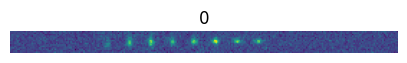

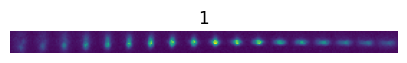

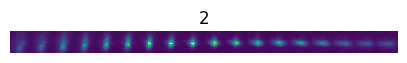

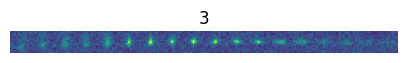

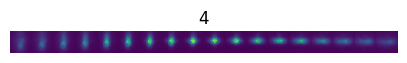

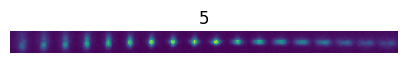

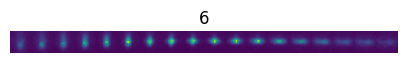

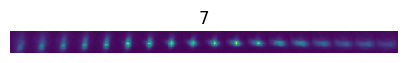

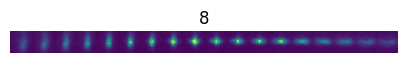

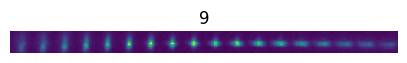

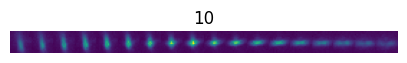

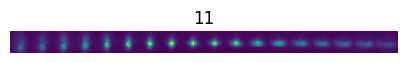

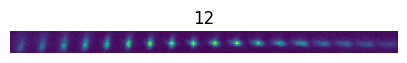

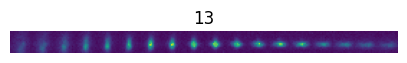

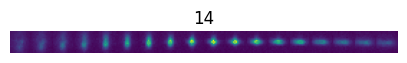

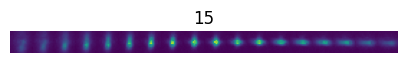

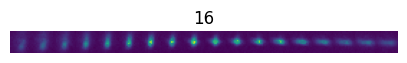

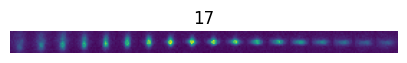

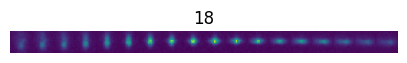

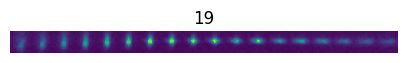

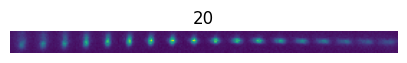

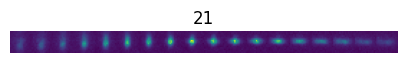

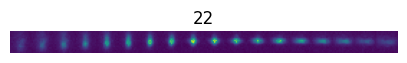

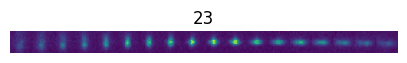

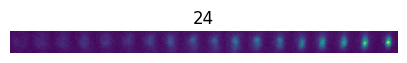

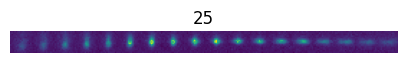

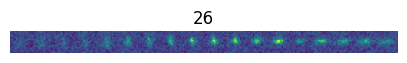

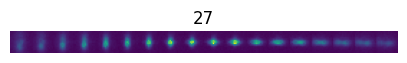

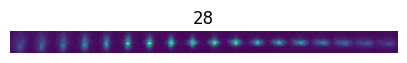

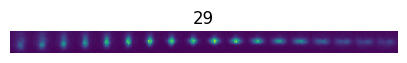

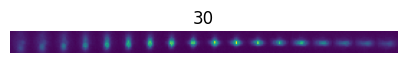

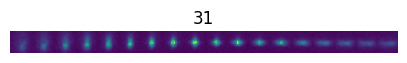

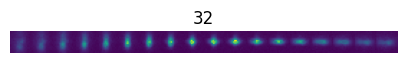

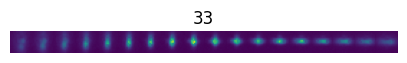

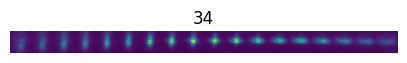

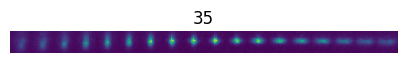

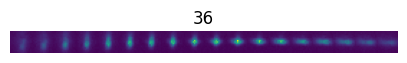

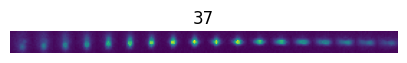

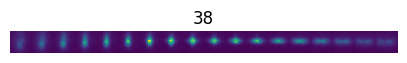

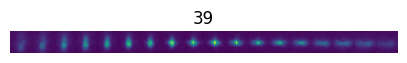

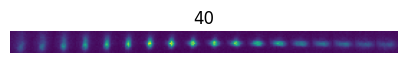

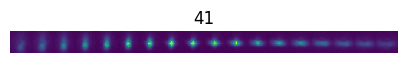

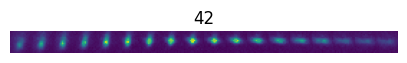

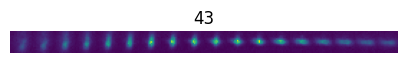

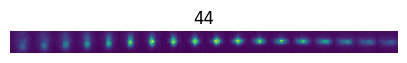

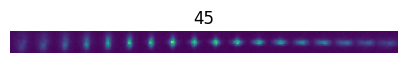

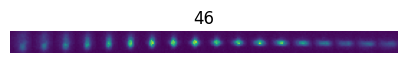

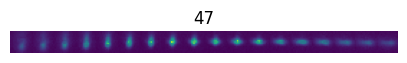

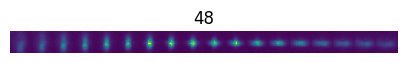

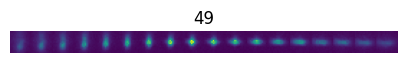

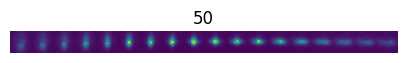

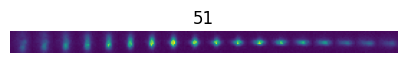

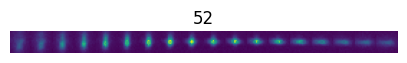

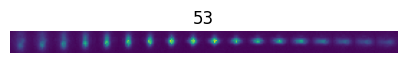

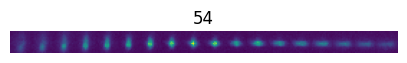

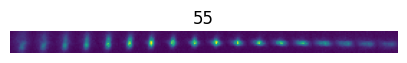

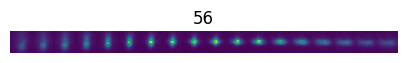

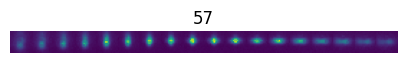

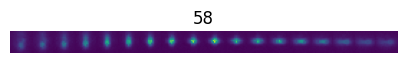

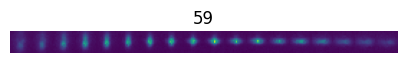

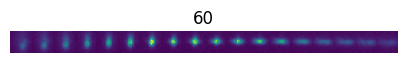

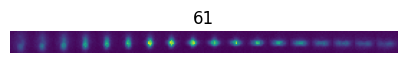

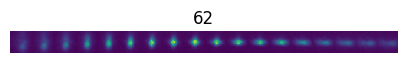

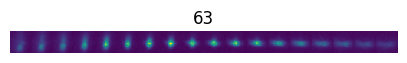

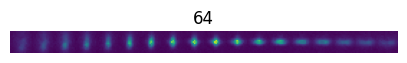

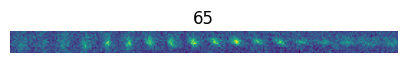

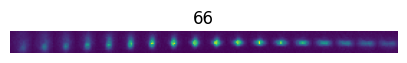

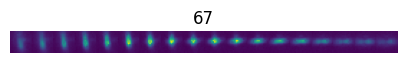

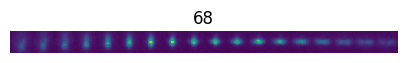

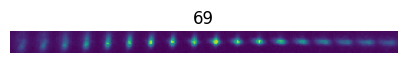

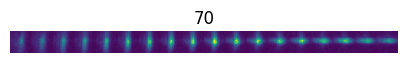

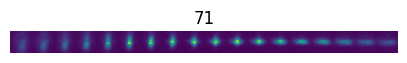

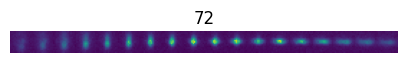

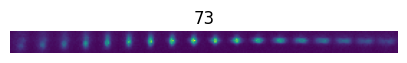

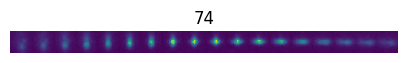

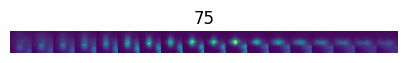

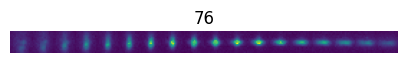

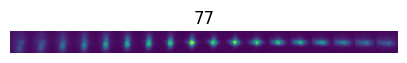

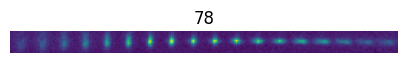

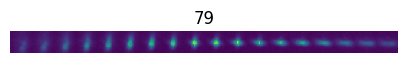

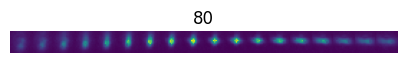

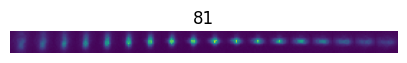

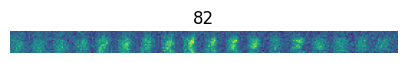

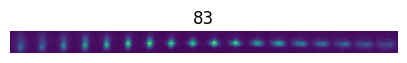

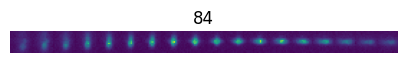

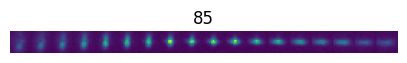

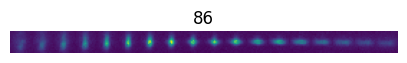

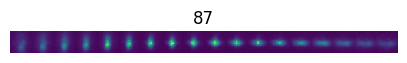

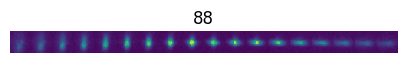

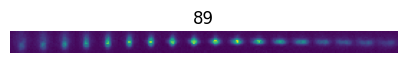

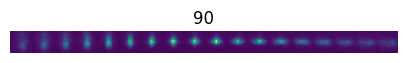

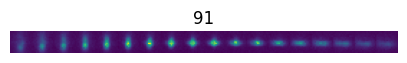

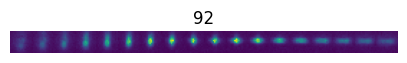

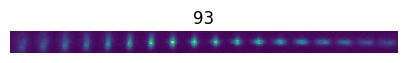

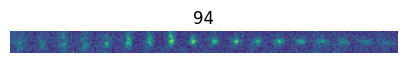

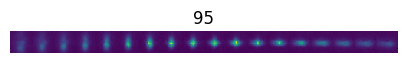

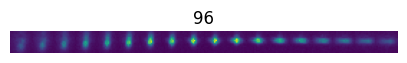

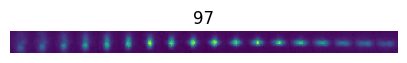

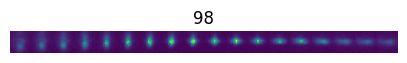

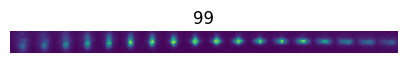

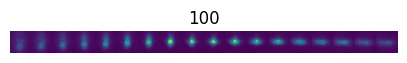

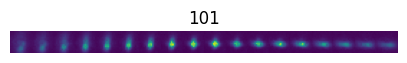

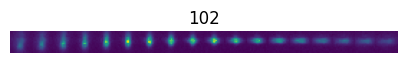

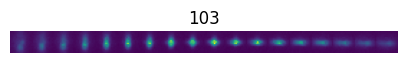

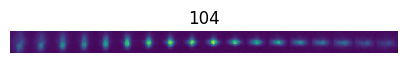

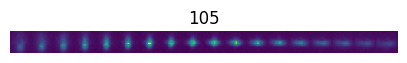

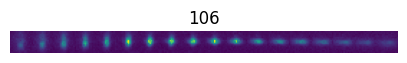

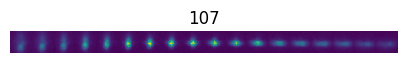

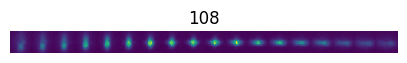

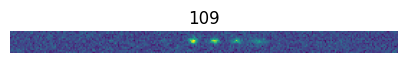

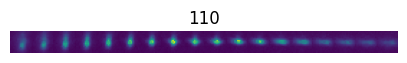

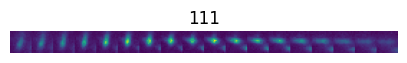

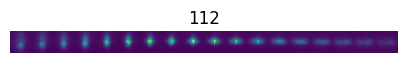

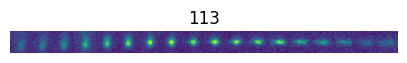

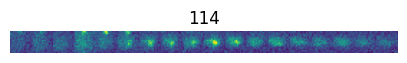

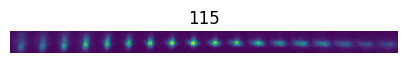

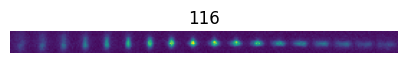

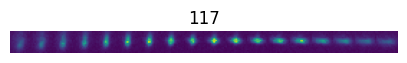

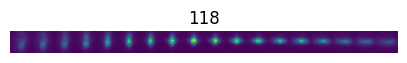

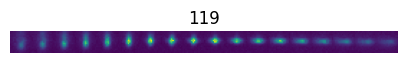

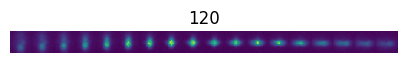

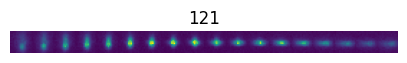

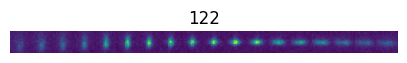

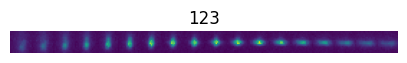

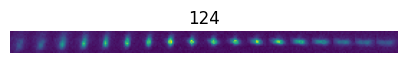

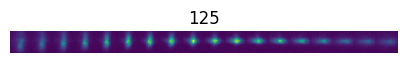

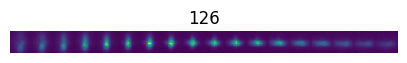

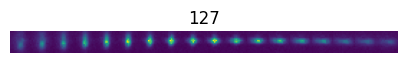

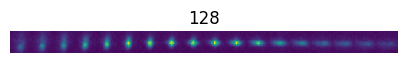

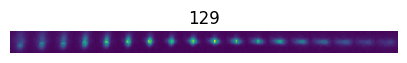

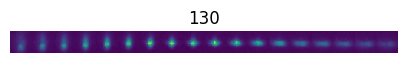

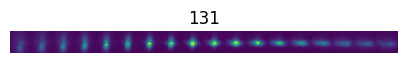

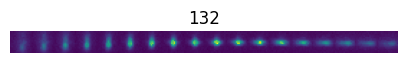

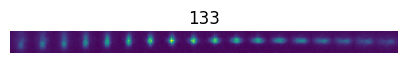

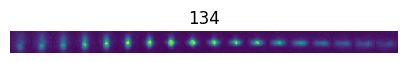

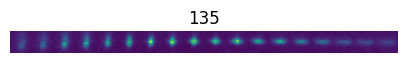

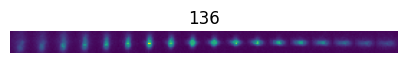

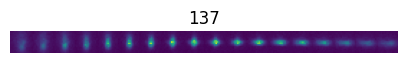

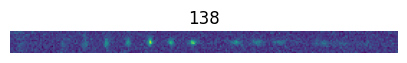

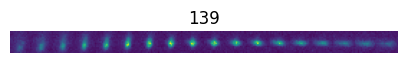

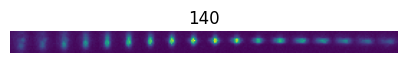

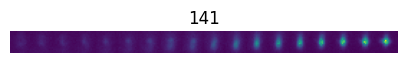

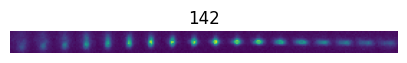

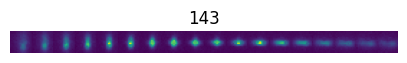

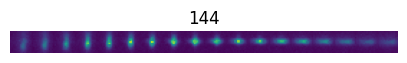

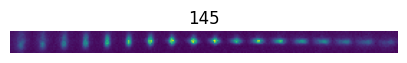

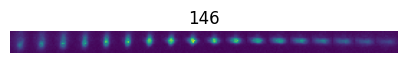

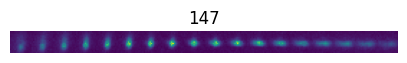

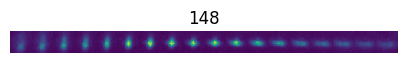

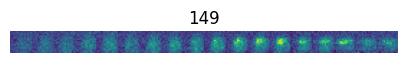

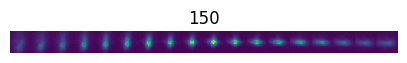

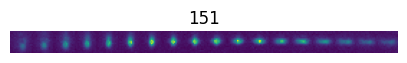

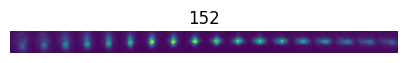

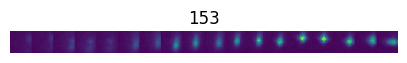

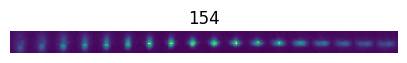

In [5]:
from data.visualise import show_psf_axial
plt.rcParams['figure.figsize'] = [5, 3]
for i, psf in enumerate(psfs[0:200]):
    show_psf_axial(psf.mean(axis=-1), str(i))


In [6]:
# exclude_idx = [35, 55, 60, 96, 104, 113, 128, 132, 230, 234]
exclude_idx = [82, 109, 114, 138, 141, 149, 153]
# exclude_idx = []
idx = [i for i in range(psfs.shape[0]) if i not in exclude_idx]
psfs = psfs[idx]
locs = locs.iloc[idx]

2023-08-15 16:04:20.517366: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 16:04:21.071230: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
0it [00:00, ?it/s]

[1555]


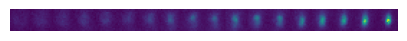

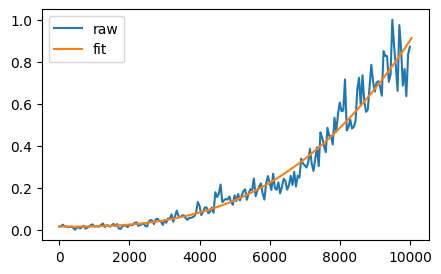

148it [00:00, 942.92it/s]


In [7]:
# Spline peak finding
from tqdm import tqdm
import numpy as np
Z_STEP = 50

from scipy.interpolate import UnivariateSpline
from data.align_psfs import norm_zero_one

UPSCALE_RATIO = 10

bad_psfs_idx = []

def find_peak(i, psf):
    if psf.ndim == 4:
        psf = psf.mean(axis=-1)
    x = np.arange(psf.shape[0]) * Z_STEP
    inten = norm_zero_one(psf.max(axis=(1,2)))
#   prev 0.8

#     cs = UnivariateSpline(x, inten, k=3, s=1.25)

#     x_ups = np.linspace(0, psf.shape[0], len(x) * UPSCALE_RATIO) * Z_STEP
    
    
    
#     peak_idx = np.argmax(cs(x_ups))
#     center_x = len(x_ups) / 2
#     if abs(center_x - peak_idx) > 250:
#         bad_psfs_idx.append(i)
        
# #         show_psf_axial(psf)
# #         plt.plot(x-peak, inten, label='raw')
# #         plt.plot(x_ups-peak, cs(x_ups), label='fit')
# #         plt.legend()
# #         plt.show()

    cs = UnivariateSpline(x, inten, k=3, s=1.25)

    x_ups = np.linspace(0, psf.shape[0], len(x) * UPSCALE_RATIO) * Z_STEP

    peak_xups = x_ups[np.argmax(cs(x_ups))] 

    fit = cs(x_ups)
    
    peak = max(fit)
    low = min(fit)
    half_max = (peak - low) / 2
    
    peak_idx = np.argmax(fit)
    center_x = len(x_ups) / 2
    
    half_max_crossings = np.where(np.diff(np.sign(fit-half_max)))[0]
    if len(half_max_crossings) < 2:
        print(half_max_crossings)
        bad_psfs_idx.append(i)
        show_psf_axial(psf)
        plt.plot(x-peak, inten, label='raw')
        plt.plot(x_ups-peak, cs(x_ups), label='fit')
        plt.legend()
        plt.show()
    
    return peak_xups

offsets = np.array([find_peak(i, psf) for i, psf in tqdm(enumerate(psfs))])

good_idx = [i for i in range(len(psfs)) if i not in bad_psfs_idx]

offsets = offsets[good_idx]
psfs = psfs[good_idx]
locs = locs.iloc[good_idx]



In [8]:

ys = []
for i, offset in enumerate(offsets):
    zs = ((np.arange(psfs.shape[1])) * Z_STEP) -offset
    ys.append(zs)

ys = np.array(ys)


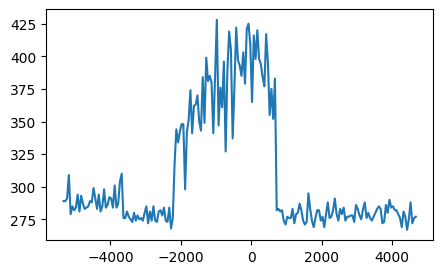

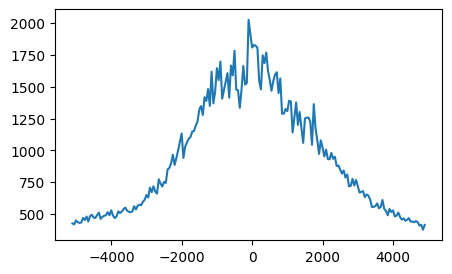

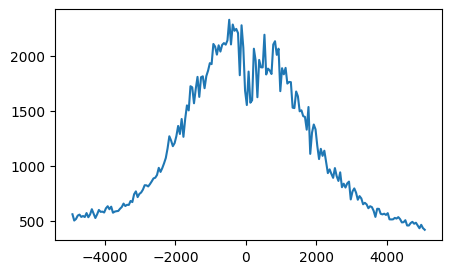

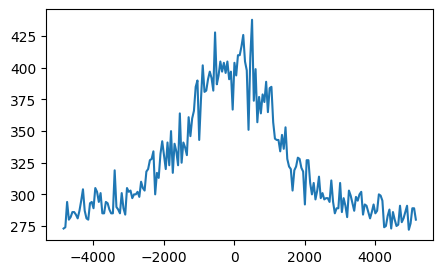

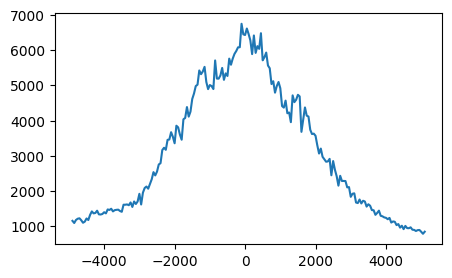

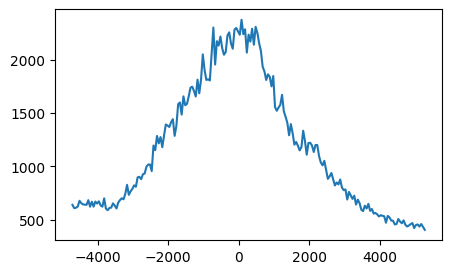

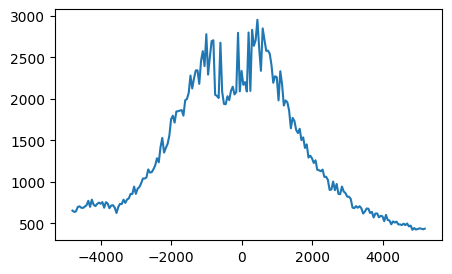

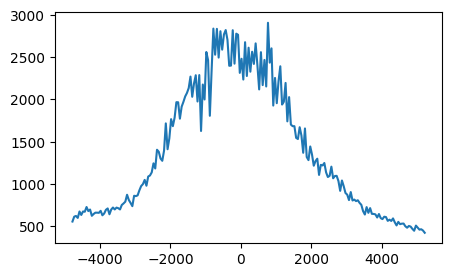

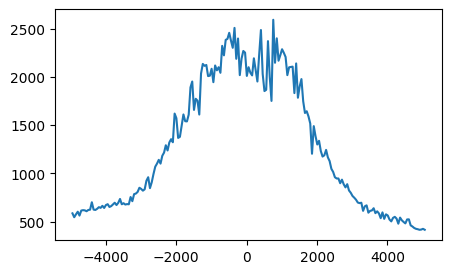

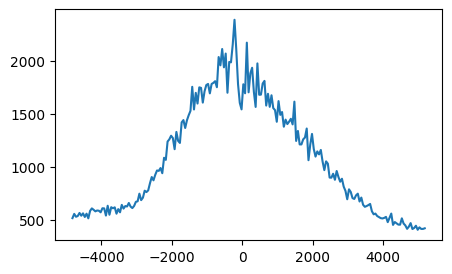

In [9]:
for psf, y in zip(psfs[0:10], ys):
    plt.plot(y, psf.max(axis=(1,2,3)))
    plt.show()

<AxesSubplot:xlabel='x', ylabel='y'>

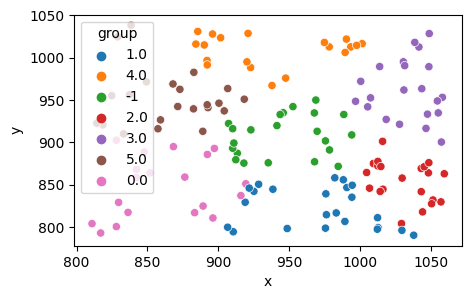

In [10]:
# Stratify according to area of FOV

from sklearn.preprocessing import KBinsDiscretizer
def cart2pol(xy):
    x, y = xy
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

center = locs[['x', 'y']].mean().to_numpy()
coords = locs[['x', 'y']].to_numpy() - center

polar_coords = np.stack([cart2pol(xy) for xy in coords])

discretizer = KBinsDiscretizer(n_bins=6, encode='ordinal')
groups = discretizer.fit_transform(polar_coords[:, 1:2]).astype(str)

center_radius = 50
idx = np.argwhere(polar_coords[:, 0] <= center_radius).squeeze()
groups[idx] = -1

locs['group'] = groups

sns.scatterplot(data=locs, x='x', y='y', hue='group')


In [11]:
# Withold some PSFs for evaluation

from sklearn.model_selection import train_test_split

SEED = 42

idx = np.arange(psfs.shape[0])

train_idx, test_idx = train_test_split(idx, train_size=0.9, random_state=SEED, stratify=locs['group'])

_train_val_psfs = psfs[train_idx]
test_psfs = psfs[test_idx]

_train_val_ys = ys[train_idx]
test_ys = ys[test_idx]

train_fov_groups = locs['group'].to_numpy()[train_idx]

train_val_coords = locs[['x', 'y']].to_numpy()[train_idx]
test_coords = locs[['x', 'y']].to_numpy()[test_idx]

# ds_cls = np.zeros((psfs.shape[0]), dtype=object)
# ds_cls[train_idx] = 'train/val'
# ds_cls[test_idx] = 'test'
# locs['ds'] = ds_cls
# sns.scatterplot(data=locs, x='x', y='y', hue='ds')
# plt.show()

In [12]:

groups = np.repeat(np.arange(len(train_idx))[:, np.newaxis], psfs.shape[1], axis=1).flatten()

coords = np.repeat(train_val_coords[:, :, np.newaxis], psfs.shape[1], axis=0)

train_val_psfs = np.concatenate(_train_val_psfs)
train_val_ys = np.concatenate(_train_val_ys)
split_idx = np.arange(train_val_psfs.shape[0])

train_idx, val_idx = train_test_split(split_idx, train_size=0.9, random_state=SEED, stratify=groups)

train_psfs = train_val_psfs[train_idx]
train_ys = train_val_ys[train_idx][:, np.newaxis]

val_psfs = train_val_psfs[val_idx]
val_ys = train_val_ys[val_idx][:, np.newaxis]

val_coords = coords[val_idx].squeeze()
train_coords = coords[train_idx].squeeze()



In [13]:
# print(train_psfs.shape, train_ys.shape, _train_groups.shape)
# print(val_psfs.shape, val_ys.shape, _val_groups.shape)


In [14]:
# from sklearn.preprocessing import OneHotEncoder

# encoder = OneHotEncoder().fit(_train_groups)

# train_groups = encoder.transform(_train_groups).toarray()
# val_groups = encoder.transform(_val_groups).toarray()

# print(train_psfs.shape, train_ys.shape, train_groups.shape)
# print(val_psfs.shape, val_ys.shape, val_groups.shape)


In [15]:
# Trim stacks

def filter_z_range(X, zs):
    psfs, groups = X
    valid_ids = np.argwhere(abs(zs.squeeze()) < Z_RANGE).squeeze()
    return [psfs[valid_ids], groups[valid_ids]], zs[valid_ids]
    
Z_RANGE = 1000
X_train, y_train = filter_z_range((train_psfs, train_coords), train_ys)

X_val, y_val = filter_z_range((val_psfs, val_coords), val_ys)


(4789, 15, 15, 1) 190.0 6749.0 431.04845734437714
Rows 20 Cols 10 n_spaces 200 n_psfs 200
20


2023-08-15 16:04:23.252549: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22142 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


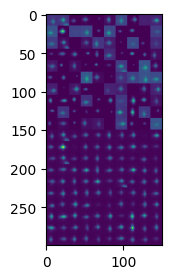

(9578, 15, 15, 1) 190.0 6749.0 555.3761486145177


In [16]:
# data augmentation


from tensorflow.keras import layers, Sequential
from data.visualise import grid_psfs

def aug_dataset(X_train, y_train):
    AUG_RATIO = 1
    MAX_TRANSLATION_PX = 2
    MAX_GAUSS_NOISE = 0.001
    img_size = X_train[0].shape[1]

    aug_pipeline = Sequential([
        layers.GaussianNoise(stddev=MAX_GAUSS_NOISE*X_train[0].max(), seed=SEED),
        layers.RandomTranslation(MAX_TRANSLATION_PX/img_size, MAX_TRANSLATION_PX/img_size, seed=SEED),
        layers.RandomBrightness(0.2, [X_train[0].min(), X_train[0].max()], seed=SEED)
    ])

    idx = np.random.randint(0, X_train[0].shape[0], size=int(AUG_RATIO*X_train[0].shape[0]))

    aug_psfs = aug_pipeline(X_train[0][idx].copy(), training=True).numpy()
    aug_coords = X_train[1][idx]

    aug_z = y_train[idx]

    subset_psfs = np.concatenate((aug_psfs[0:100], X_train[0][idx][0:100]))
    plt.imshow(grid_psfs(subset_psfs.mean(axis=-1)))
    plt.show()

    train_psfs = np.concatenate([aug_psfs, X_train[0]])
    train_coords = np.concatenate([aug_coords, X_train[1]])
    train_zs = np.concatenate([aug_z, y_train])

    X_train = [train_psfs, train_coords]
    y_train = train_zs
    return X_train, y_train

X_train[0] = X_train[0].astype(float)
print(X_train[0].shape, X_train[0].min(), X_train[0].max(), X_train[0].mean())
X_train, y_train = aug_dataset(X_train, y_train)
print(X_train[0].shape, X_train[0].min(), X_train[0].max(), X_train[0].mean())

X_train[0] = X_train[0].astype(np.uint16)

In [17]:
from skimage.transform import resize

def resize_psfs(X):
    print('Resizing...')
    target_size = 128
    imshape = (target_size, target_size, 3)
    X[0] = np.stack([resize(psf, imshape) for psf in X[0]])
    print(X[0].shape)
    print('Finished')

resize_psfs(X_train)
resize_psfs(X_val)

Resizing...
(9578, 128, 128, 3)
Finished
Resizing...
(491, 128, 128, 3)
Finished


In [18]:
print(X_train[0].shape, X_train[1].shape, y_train.shape)
print(X_val[0].shape, X_val[1].shape, y_val.shape)


(9578, 128, 128, 3) (9578, 2) (9578, 1)
(491, 128, 128, 3) (491, 2) (491, 1)


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0/65336.0,
    samplewise_center=False,
    samplewise_std_normalization=False,
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=False)

print('Fitting datagen...')
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train[0])
print('Fitted')

X_train_preproc = [X_train[0].copy(), X_train[1].copy()]
X_val_preproc = [X_val[0].copy(), X_val[1].copy()]

X_train_preproc[0] = datagen.standardize(X_train_preproc[0].astype(float))
X_val_preproc[0] = datagen.standardize(X_val_preproc[0].astype(float))

# preprocessors = {
#     'psfs': datagen,
#     'coords': coords_scaler
# }

# import pickle
# with open('./scalers.p', 'wb') as f:
#     pickle.dump(preprocessors, f)

Fitting datagen...
Fitted


In [20]:
test_psfs = psfs[test_idx]

test_ys = ys[test_idx]


test_groups = np.repeat(np.arange(len(test_psfs))[:, np.newaxis], test_psfs.shape[1], axis=1)
test_groups = np.concatenate(test_groups)

test_coords = np.repeat(test_coords[:, :, np.newaxis], test_psfs.shape[1], axis=0).squeeze()

test_psfs = np.concatenate(test_psfs)

print(test_psfs.shape, test_coords.shape)

test_ys = np.concatenate(test_ys)[:, np.newaxis]

X_test, y_test = filter_z_range((test_psfs, test_coords), test_ys)

test_groups = X_test[1].copy()


resize_psfs(X_test)
X_test_preproc = [X_test[0].copy(), X_test[1].copy()]
X_test_preproc[0] = datagen.standardize(X_test_preproc[0].astype(float))

print(X_test_preproc[0].shape, X_test_preproc[1].shape, y_test.shape)


(3015, 15, 15, 1) (3015, 2)
Resizing...
(600, 128, 128, 3)
Finished
(600, 128, 128, 3) (600, 2) (600, 1)


In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_preproc[1] = scaler.fit_transform(X_train_preproc[1])
X_val_preproc[1] = scaler.transform(X_val_preproc[1])
X_test_preproc[1] = scaler.transform(X_test_preproc[1])

In [22]:
print(X_train_preproc[0].min(), X_train_preproc[0].max())
print(X_val_preproc[0].min(), X_val_preproc[0].max())

print(X_train_preproc[1].min(), X_train_preproc[1].max())
print(X_val_preproc[1].min(), X_val_preproc[1].max())

print(X_train_preproc[0].shape, X_train_preproc[1].shape)
print(X_val_preproc[0].shape, X_val_preproc[1].shape)

-0.014387552933885195 1.3392896257648992
-0.012205777937958157 1.1961108286163713
-1.9437401 1.9186138
-1.9437401 1.9186138
(9578, 128, 128, 3) (9578, 2)
(491, 128, 128, 3) (491, 2)


(487, 128, 128)
Rows 49 Cols 10 n_spaces 490 n_psfs 487
49


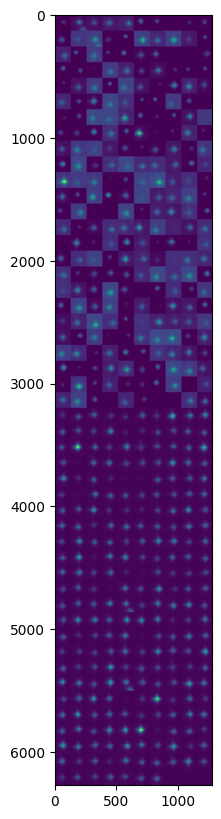

In [23]:
train_idx = np.argwhere(abs(y_train.squeeze()) < 50).squeeze()
tmp_psfs = X_train_preproc[0][train_idx].mean(axis=-1)
print(tmp_psfs.shape)
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(grid_psfs(tmp_psfs))
plt.show()

In [24]:
X_train_imgs = X_train_preproc[0]
X_val_imgs = X_val_preproc[0]
X_test_imgs = X_test_preproc[0]

In [26]:
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tqdm.keras import TqdmCallback
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from vit_keras import vit

# Assuming your input images have size (image_size, image_size, num_channels)
image_size = X_train_imgs.shape[1]
num_channels = X_train_imgs.shape[-1]
num_classes = 1  # Regression task, predicting a single continuous value

# Create the Vision Transformer model using the vit_keras library
inputs = Input(shape=(image_size, image_size, num_channels))

coords_input = layers.Input(X_train_preproc[1][0].shape)
x_coords = layers.Dense(64)(coords_input)

x_coords = layers.Dense(64)(x_coords)


print(inputs.shape)
vit_model = vit.vit_b16(image_size=image_size, 
                        activation='sigmoid',
                        pretrained=True,
                        include_top=False,
                        pretrained_top=False)

x = vit_model(inputs)
# Add additional layers for regression prediction
x = Flatten()(x)
x = tf.concat([x, x_coords], axis=-1)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
regression_output = Dense(num_classes, activation='linear')(x)  # Linear activation for regression

# Combine the Vision Transformer backbone with the regression head
model = Model(inputs=[inputs, coords_input], outputs=regression_output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Print a summary of the model architecture
model.summary()

batch_size = 128
epochs = 5000
lr = 0.0001

model.compile(loss='mean_squared_error', optimizer=optimizers.AdamW(learning_rate=lr), metrics=['mean_absolute_error'])

callbacks = [
    ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.1,
                      patience=50, verbose=True, mode='min', min_delta=5, min_lr=1e-6,),
    EarlyStopping(monitor='val_mean_absolute_error', patience=75,
                  verbose=False, min_delta=1, restore_best_weights=True),
    TqdmCallback(verbose=1),
]


history = model.fit(X_train_preproc, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val_preproc, y_val), callbacks=callbacks, shuffle=True, verbose=False)


(None, 128, 128, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_5 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 vit-b16 (Functional)           (None, 768)          85697280    ['input_4[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 64)           192         ['input


Epoch 76: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# from tensorflow import keras
# from tensorflow.keras import layers, Sequential
# from tensorflow.keras import optimizers
# from keras.callbacks import ReduceLROnPlateau, EarlyStopping
# from tqdm.keras import TqdmCallback
# from tensorflow.keras import regularizers

# import tensorflow as tf

# def train_model(X_train_preproc, y_train, X_val_preproc, y_val):
#     img_input = layers.Input((X_train_preproc[0][0].shape))
#     x = img_input
    
#     coords_input = layers.Input(X_train_preproc[1][0].shape)
#     x_coords = layers.Dense(64)(coords_input)
    
#     x_coords = layers.Dense(64)(x_coords)

#     x = keras.applications.ResNet101V2(
#         input_tensor = img_input,
#         include_top=False,
#         pooling='max',
# #         weights='imagenet',
#     )(x)

# #     x = keras.applications.MobileNetV3Small(
# #         input_tensor=img_input,
# #         include_top=False,
# #         pooling='avg',
# #     )(x)
# #     x = keras.applications.MobileNet(
# #         input_tensor=img_input,
# #         include_top=False,
# #         weights='../mobilenet_1_0_128_tf_no_top.h5',
# #         pooling='max',
# #     )(x)

#     x = tf.concat([x, x_coords], axis=-1)
    
# #     x = layers.Dense(64, activation='relu')(x)
# #     x = layers.Dropout(0.5)(x)
# #     x = layers.Dense(64, activation='relu')(x)
#     x = layers.Dropout(0.5)(x)
#     out = layers.Dense(1, activation="linear",
#                        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
#                        bias_regularizer=regularizers.L2(1e-4),
#                        activity_regularizer=regularizers.L2(1e-5)
#                       )(x)

#     model = keras.Model(inputs=(img_input, coords_input), outputs=out)

#     model.summary(expand_nested=False)


#     batch_size = 256
#     epochs = 5000
#     lr = 0.0001

#     model.compile(loss='mean_squared_error', optimizer=optimizers.AdamW(learning_rate=lr), metrics=['mean_absolute_error'])

#     callbacks = [
#         ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.1,
#                           patience=50, verbose=True, mode='min', min_delta=5, min_lr=1e-6,),
#         EarlyStopping(monitor='val_mean_absolute_error', patience=75,
#                       verbose=False, min_delta=1, restore_best_weights=True),
#         TqdmCallback(verbose=1),
#     ]


#     history = model.fit(X_train_preproc, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val_preproc, y_val), callbacks=callbacks, shuffle=True, verbose=True)

# #     model.save('./latest_model')
#     return model, history

# # X_train_preproc[1][:] = 0
# # X_val_preproc[1][:] = 0
# model, history = train_model(X_train_preproc, y_train, X_val_preproc, y_val)


In [ ]:
model.save('./latest_model')

In [ ]:
#     AUG_RATIO = 1
#     MAX_TRANSLATION_PX = 2
#     MAX_GAUSS_NOISE = 0.001
#     img_size = X_train[0].shape[1]

#     aug_pipeline = Sequential([
#         layers.GaussianNoise(stddev=MAX_GAUSS_NOISE*X_train[0].max(), seed=SEED),
#         layers.RandomTranslation(MAX_TRANSLATION_PX/img_size, MAX_TRANSLATION_PX/img_size, seed=SEED),
#         layers.RandomBrightness(0.2, [X_train[0].min(), X_train[0].max()], seed=SEED)
#     ])

# train 41.962
# 16/16 [==============================] - 0s 18ms/step
# val 59.407
# 19/19 [==============================] - 0s 16ms/step
# test 42.7




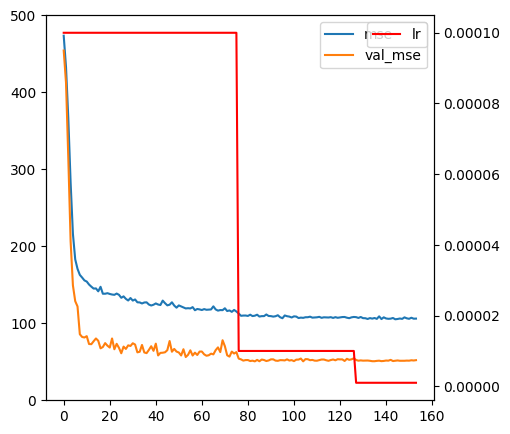

In [27]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [5, 5]
fig, ax1 = plt.subplots()
ax1.plot(history.history['mean_absolute_error'], label='mse')
ax1.plot(history.history['val_mean_absolute_error'], label='val_mse')
ax1.set_ylim([0, 500])
ax1.legend(loc=1)
ax2 = ax1.twinx()
ax2.plot(history.history['lr'], label='lr', color='red')
ax2.legend(loc=0)


In [28]:
from sklearn.metrics import mean_absolute_error
ds = [
    ('train', (X_train_preproc, y_train)), 
    ('val', (X_val_preproc, y_val)),
    ('test', (X_test_preproc, y_test))
]
for k, (X, y) in ds:
    res = model.predict(X, verbose=True)
    error = mean_absolute_error(res, y)
    print(k, round(error, 3))

300/300 [==============================] - 13s 38ms/step
train 50.789
16/16 [==============================] - 1s 39ms/step
val 51.506
19/19 [==============================] - 1s 40ms/step
test 73.579


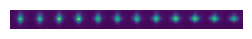

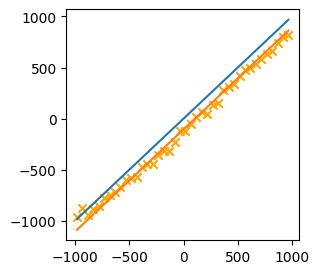

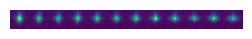

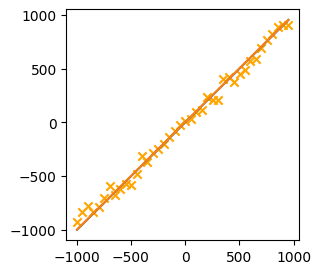

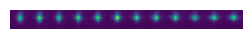

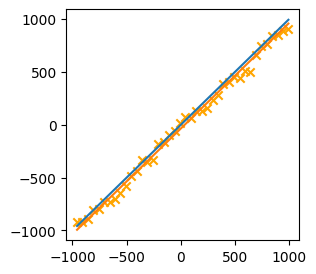

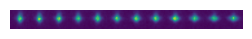

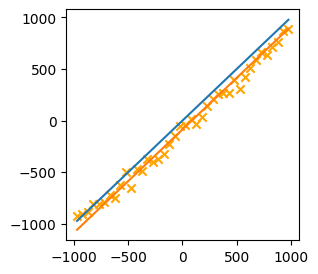

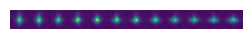

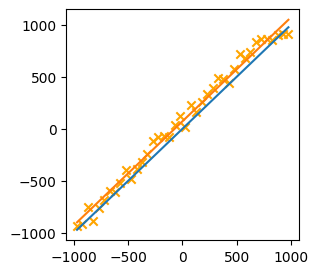

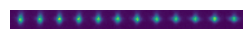

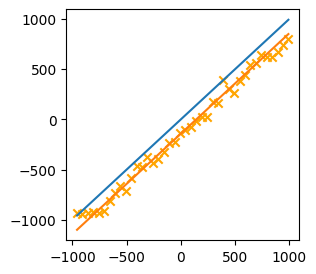

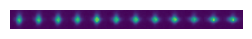

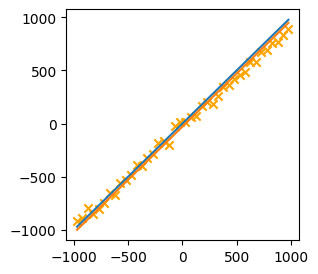

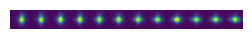

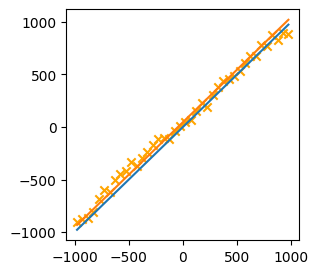

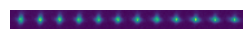

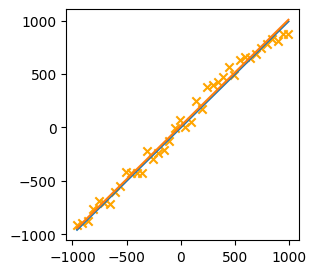

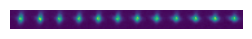

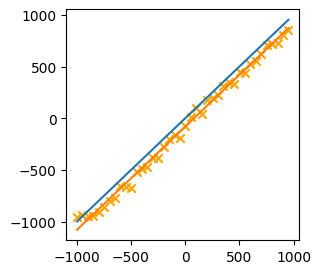

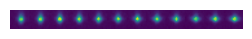

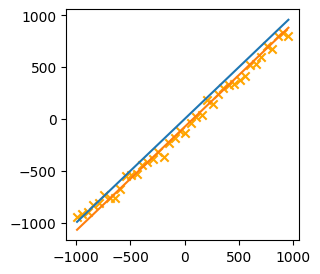

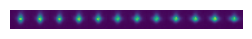

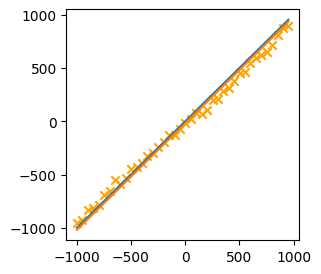

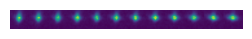

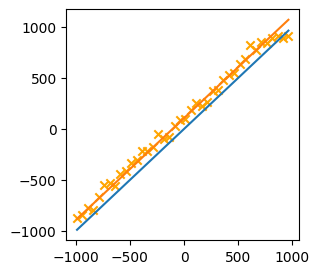

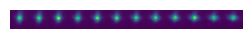

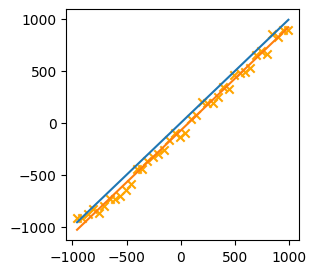

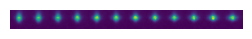

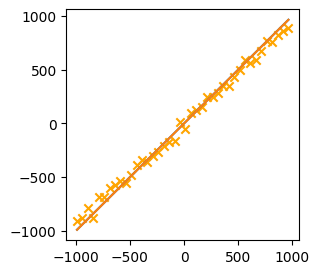

test 41.417


In [29]:
# MAE without located error
import scipy.optimize as opt
from sklearn.preprocessing import LabelEncoder
plt.rcParams['figure.figsize'] = [3,3]
def bestfit_error(z_true, z_pred):
    def linfit(x, c):
        return x + c

    x = z_true
    y = z_pred
    popt, _ = opt.curve_fit(linfit, x, y, p0=[0])

    x = np.linspace(z_true.min(), z_true.max(), len(y))
    y_fit = linfit(x, popt[0])
    error = mean_absolute_error(y_fit, y)
    plt.plot(x, x, label=f'x=y')
    plt.plot(x, y_fit, label=f'best_fit c={popt[0]}')
    plt.scatter(z_true, z_pred, marker='x', c='orange')
    plt.show()
    return error, popt[0], y_fit-y

ds = [
#     ('train', (X_train_preproc, y_train)),
    ('test', (X_test_preproc, y_test))
]

res = {}
for k, (X, y) in ds:
    pred_z = model.predict(X, verbose=False)
    res[k] = []
    labels = X[1].astype(str)
    labels = [','.join(list(arr)) for arr in labels]
    label_ids = LabelEncoder().fit_transform(labels)
    
    y = y.squeeze()
    for g in set(label_ids):
        idx = np.argwhere(label_ids==g)[:, 0]
        group_psfs = X[0][idx]
        show_psf_axial(group_psfs.mean(axis=-1), '', 2)
        group_true_zs = y[idx]
        group_pred_zs = pred_z[idx][:, 0]
        if len(idx) == 1:
            res[k].append([mean_absolute_error(group_true_zs, group_pred_zs)])
        else:
            error, offset, errors = bestfit_error(group_true_zs, group_pred_zs)
            res[k].extend(errors)

for k, v in res.items():
    print(k, round(np.mean(np.abs(v)), 3))

In [30]:
for k, v in res.items():
    print(k, round(np.mean(np.abs(v)), 3))

test 41.417


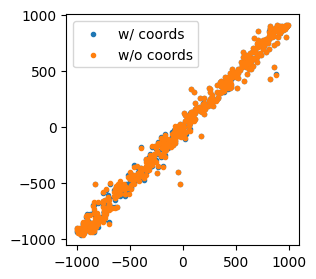

51.50628380788024
51.61416163712967


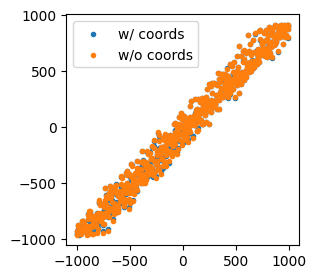

73.57874239858091
74.06797360760443


In [31]:
# Error with xy coords
import scipy.optimize as opt
from sklearn.preprocessing import LabelEncoder

def bestfit_error(z_true, z_pred):
    def linfit(x, c):
        return x + c

    x = z_true
    y = z_pred
    popt, _ = opt.curve_fit(linfit, x, y, p0=[0])

    x = np.linspace(z_true.min(), z_true.max(), len(y))
    y_fit = linfit(x, popt[0])
    error = mean_absolute_error(y_fit, y)
    plt.plot(x, x, label=f'x=y')
    plt.plot(x, y_fit, label=f'best_fit c={popt[0]}')
    plt.scatter(z_true, z_pred, marker='x', c='orange')
    return error, popt[0], y_fit-y

ds = [
    ('val', (X_val_preproc, y_val)),
    ('test', (X_test_preproc, y_test))
]

res = {}
for k, (X, y) in ds:
    pred_z = model.predict(X, verbose=False)
    res[k] = []
    labels = X[1].astype(str)
    labels = [','.join(list(arr)) for arr in labels]
    label_ids = LabelEncoder().fit_transform(labels)
    
    X2 = X[0].copy(), X[1].copy()
    X2[1][:] = 0
    pred_z_no_coords = model.predict(X2, verbose=False)
    
    y = y.squeeze()
    plt.scatter(y, pred_z, label='w/ coords', marker='.')
    plt.scatter(y, pred_z_no_coords, label='w/o coords', marker='.')
    plt.legend()
    plt.show()
    print(mean_absolute_error(y, pred_z))
    print(mean_absolute_error(y, pred_z_no_coords))

#     for g in set(label_ids):
#         idx = np.argwhere(label_ids==g)[:, 0]
#         group_psfs = X[0][idx]
#         show_psf_axial(group_psfs.mean(axis=-1), '', 2)
#         group_true_zs = y[idx]
#         group_pred_zs = pred_z[idx][:, 0]
#         if len(idx) == 1:
#             res[k].append([mean_absolute_error(group_true_zs, group_pred_zs)])
#         else:
#             error, offset, errors = bestfit_error(group_true_zs, group_pred_zs)
#             error, offset, errors = bestfit_error(group_true_zs, pred_z_no_coords[idx][:, 0])

#         plt.show()


In [32]:
# Results
# w/               groups    no groups   no groups larger FOV
# train            18.952    11.403      12
# val              55.52     53.929      68
# test             102.356   99.47       74
# test_wo_offsets  48.838    48.318      42

# w/ No reg        groups    no groups   no groups larger FOV
# train            ______    7.9___      ______
# val              ______    54____      ______
# test             ______    126___      ______
# test_wo_offsets  ______    84____      ______


In [33]:
import pandas as pd
import h5py
import numpy as np

# MQ_DATA
dirname = '/home/miguel/Projects/uni/data/smlm_3d/20230601_MQ_celltype/nup/fov2/storm_1/'
locs = 'storm_1_MMStack_Default.ome_locs.hdf5'
spots = 'storm_1_MMStack_Default.ome_spots.hdf5'

# FD-DEEPLOC-data

dirname = '/home/miguel/Projects/uni/data/smlm_3d/fd-deeploc-data/demo2_FD_astig_NPC/'
locs = 'roi_startpos_810_790_split.ome_locs.hdf5'
spots = 'roi_startpos_810_790_split.ome_spots.hdf5'


all_locs = pd.read_hdf(dirname+locs, key='locs')
picked_locs = pd.read_hdf(dirname+locs.replace('_locs', '_locs_picked'), key='locs')

with h5py.File(dirname+spots, 'r') as f:
    spots = np.array(f['spots']).astype(np.uint16)

print(all_locs.shape)
print(picked_locs.shape)
print(spots.shape)


(257156, 12)
(257156, 12)
(257156, 15, 15)


(130.0, 150.0)

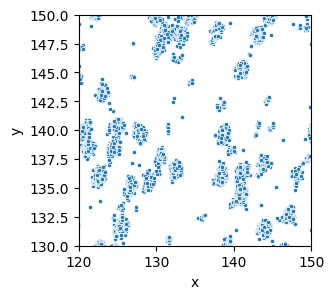

In [34]:
sns.scatterplot(data=all_locs, x='x', y='y', marker='.')
plt.rcParams['figure.figsize'] = [20, 20]

xlim = 150, 170
ylim = 130, 150

xlim = 120, 150
ylim = 130, 150
plt.xlim(*xlim)
plt.ylim(*ylim)

In [35]:

# Check values in base image vs spots
# from PIL import Image

# d = Image.open('/home/miguel/Projects/uni/data/smlm_3d/20230601_MQ_celltype/nup/fov2/storm_1/storm_1_MMStack_Default.ome.tif')
# print(d.n_frames)
# d.seek(200)
# np.array(d).max()



In [36]:
print(all_locs['x'].min(), all_locs['x'].max())
print(picked_locs['x'].min(), picked_locs['x'].max())

3.9421346 211.83617
3.9421346 211.83617


In [37]:
# MQ_data_only
if 'demo2_FD_astig_NPC' in dirname:
    
#     xlim = ((450, 750))
#     ylim = ((450, 750))

    
#     xlim = 105, 110
#     ylim = 60, 65
    l2 = picked_locs[(xlim[0]<picked_locs['x']) & (xlim[1]>picked_locs['x']) & (ylim[0]<picked_locs['y']) & (ylim[1]>picked_locs['y'])]
    all_locs = all_locs.iloc[l2.index]
    picked_locs = all_locs
    spots = spots[l2.index]

all_locs['x'] += 790
all_locs['y'] += 810
print(all_locs.shape)
print(picked_locs.shape)
print(spots.shape)


(5600, 12)
(5600, 12)
(5600, 15, 15)


In [38]:
if all_locs.shape[0] == picked_locs.shape[0]:
    idx = np.arange(all_locs.shape[0])
else:
    all_keys = list(all_locs[['bg', 'photons']].astype(str).agg('-'.join, axis=1))
    picked_keys = picked_locs[['bg', 'photons']].astype(str).agg('-'.join, axis=1)
    idx = [all_keys.index(k) for k in picked_keys]

exp_psfs = spots[idx]
print(exp_psfs.shape, picked_locs.shape)
print(exp_psfs.min(), exp_psfs.max())
try:
    print(psfs.min(), psfs.max())
    print(psfs.dtype, exp_psfs.dtype)
except NameError:
    pass

(5600, 15, 15) (5600, 12)
159 692
184 6749
uint16 uint16


Rows 10 Cols 10 n_spaces 100 n_psfs 100
10


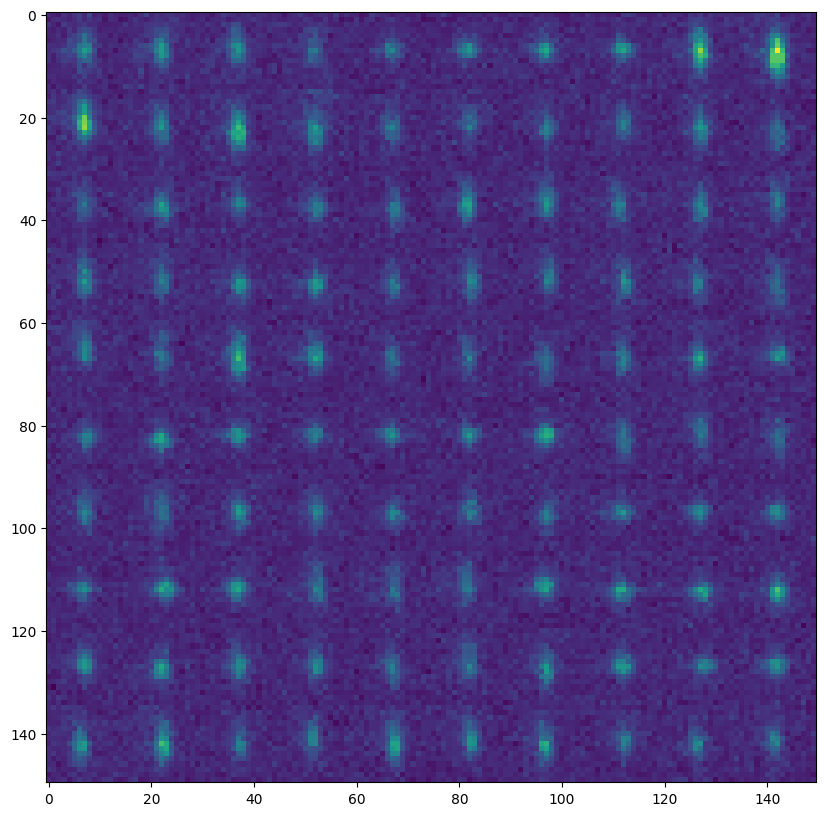

In [39]:
import matplotlib.pyplot as plt
from data.visualise import grid_psfs
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(grid_psfs(exp_psfs[0:100]))
plt.show()

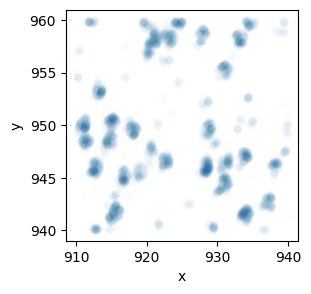

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3, 3]
sns.scatterplot(data=picked_locs, x='x', y='y', alpha=0.01)
# plt.xlim((100, 125))
# plt.ylim((50, 75))
plt.show()


In [41]:
import pickle
import keras

# with open('./scalers.p', 'rb') as f:
#     preprocessors = pickle.load(f)

model = keras.models.load_model('./latest_model/')

# datagen = preprocessors['psfs']
# coords_scaler = preprocessors['coords']

In [42]:

# print(exp_psfs_preproc.min(), exp_psfs_preproc.max())
# print(X_train_preproc[0].min(), X_train_preproc[0].max())
# print(exp_coords_preproc.min(), exp_coords_preproc.max())
# print(exp_psfs_preproc.shape, exp_coords_preproc.shape)


In [43]:
print(exp_psfs.dtype, psfs.dtype)

uint16 uint16


In [44]:
import seaborn as sns
plt.rcParams['figure.figsize'] = [10, 3]

exp_coords = picked_locs[['x', 'y']].to_numpy()
exp_coords_preproc = scaler.transform(exp_coords)

In [45]:
X_exp = [exp_psfs, exp_coords_preproc]
resize_psfs(X_exp)
X_exp[0] = datagen.standardize(X_exp[0].astype(float))

Resizing...
(5600, 128, 128, 3)
Finished


In [46]:
for X in (X_exp, X_train_preproc):
    print(X[0].min(), X[0].mean(), X[0].max())
    print(X[1].min(), X[1].max())

-0.020274211046174707 -0.007436611294926542 0.08909268566443795
-0.5664685 0.76957166
-0.014387552933885195 0.06282490802102118 1.3392896257648992
-1.9437401 1.9186138


In [50]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 dense (Dense)                  (None, 64)           192         ['input_2[0][0]']                
                                                                                                  
 mobilenet_1.00_None (Functiona  (None, 1024)        3228864     ['input_1[0][0]']            

175/175 [==============================] - 1s 4ms/step


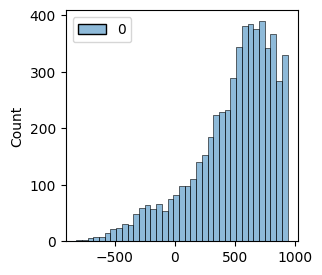

In [47]:
pred_z = model.predict(X_exp)
plt.rcParams['figure.figsize'] = [3,3]
sns.histplot(pred_z)
plt.show()




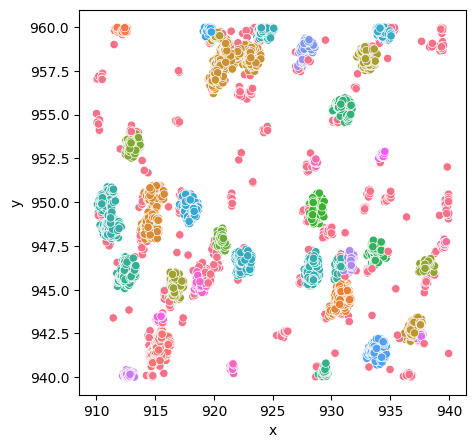

Ignoring cluster -1


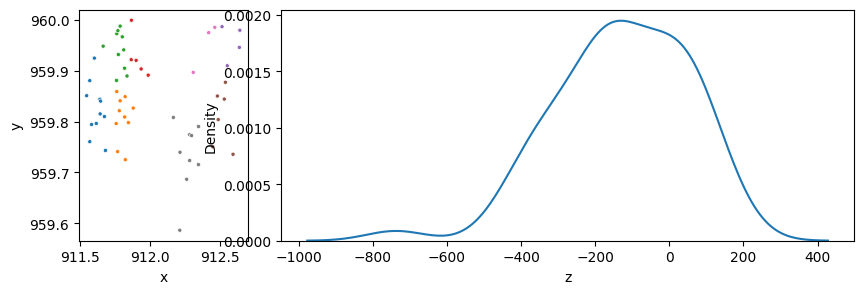

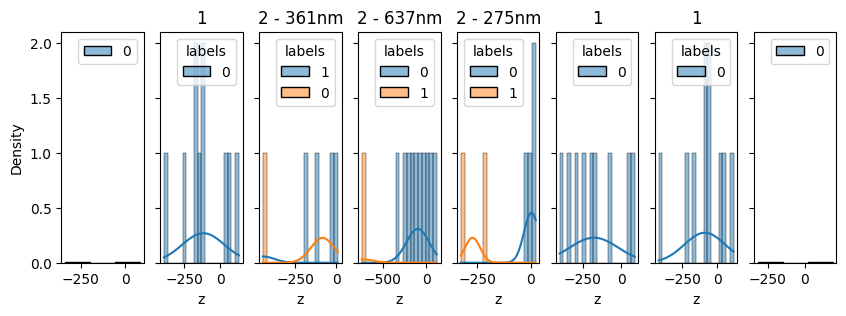

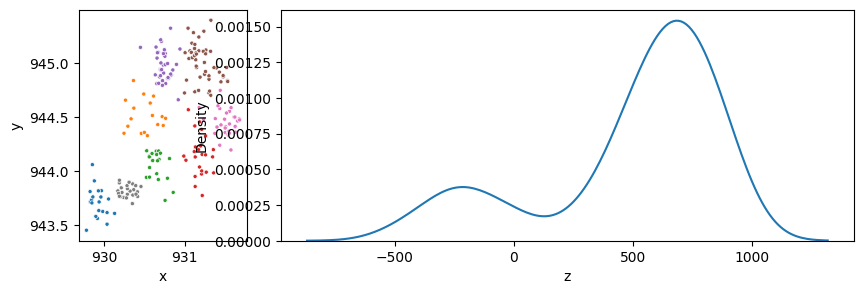

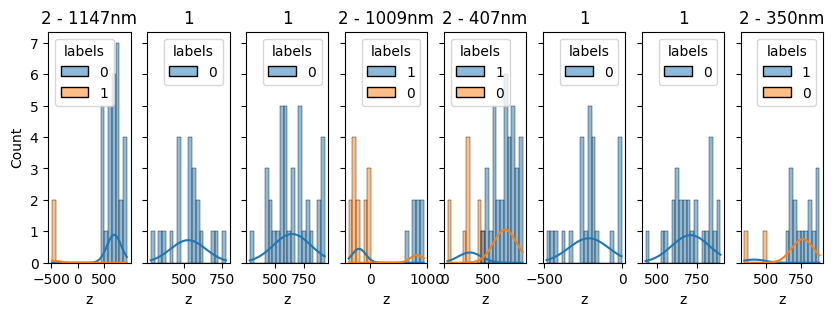

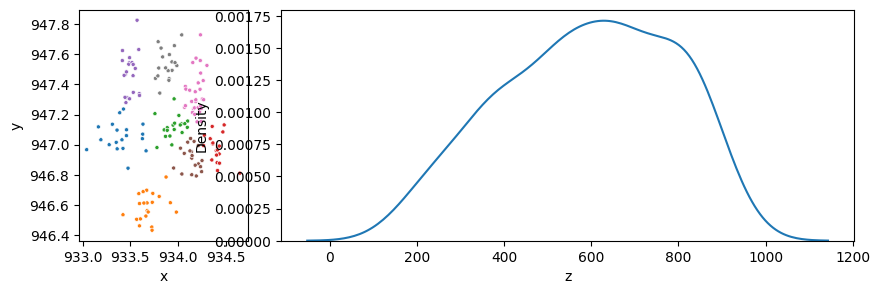

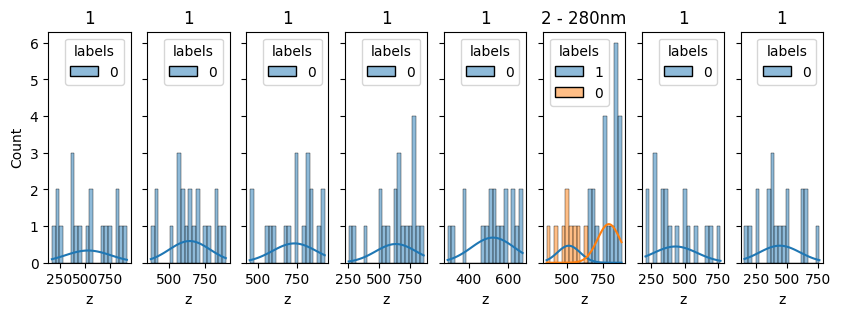

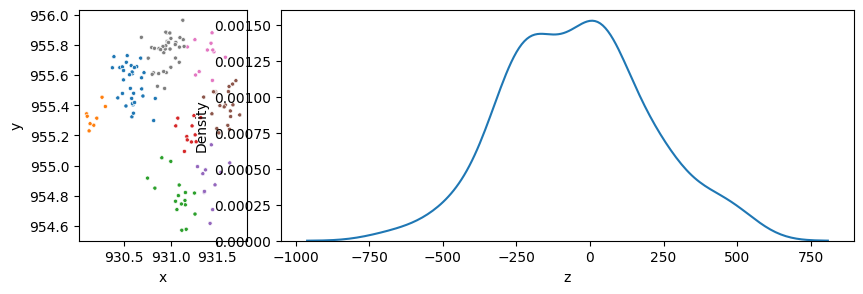

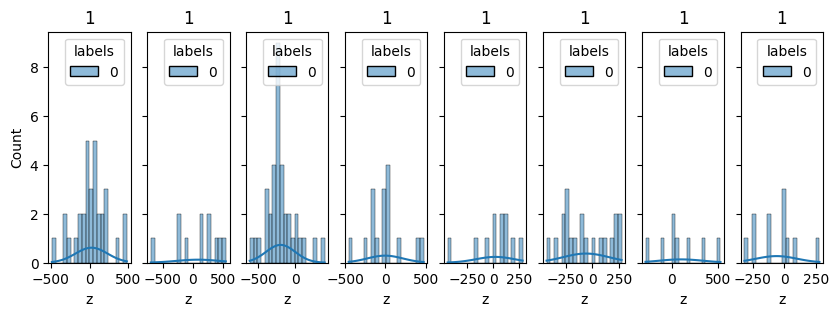

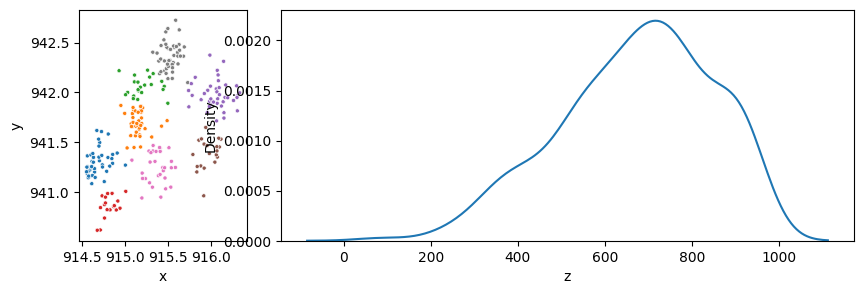

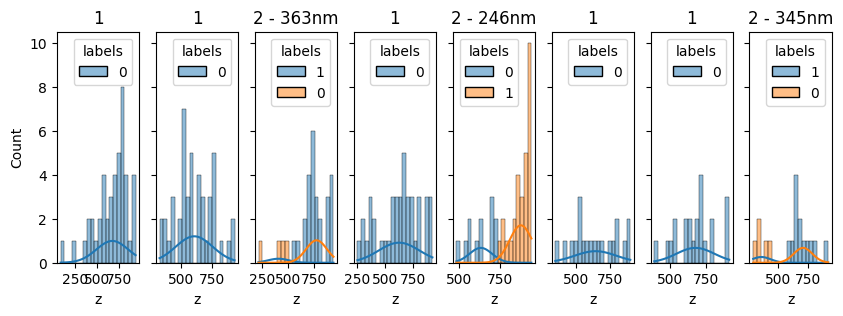

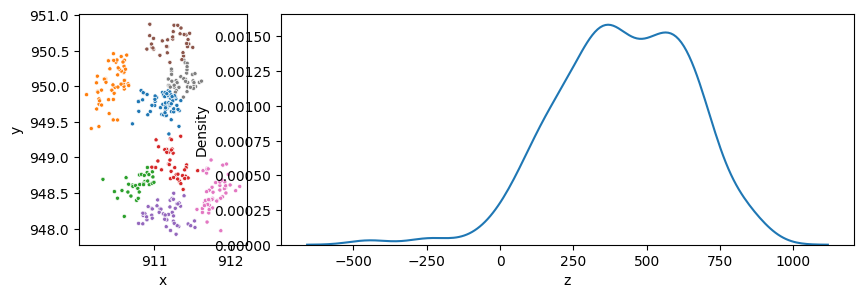

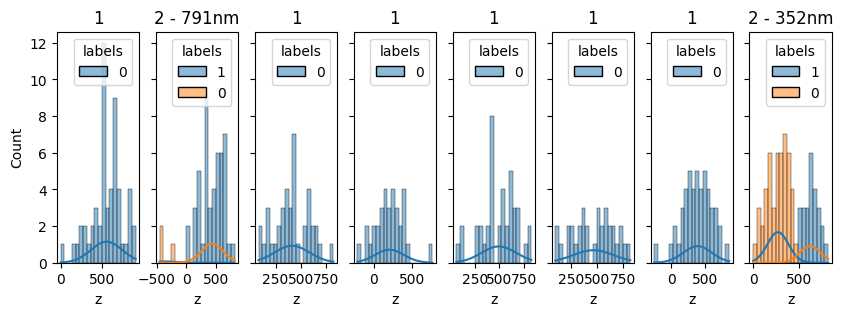

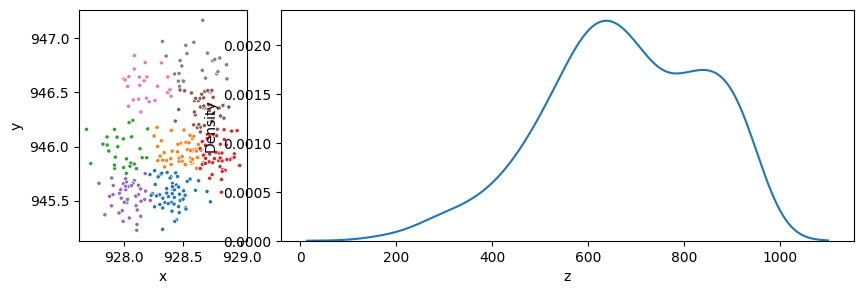

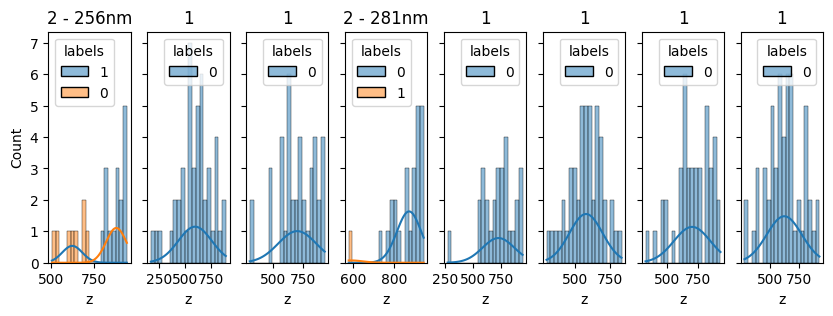

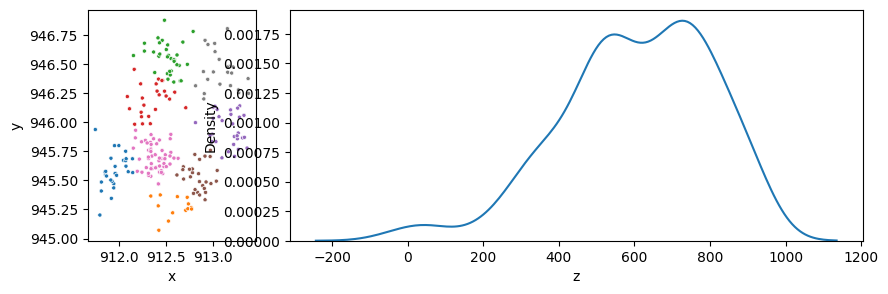

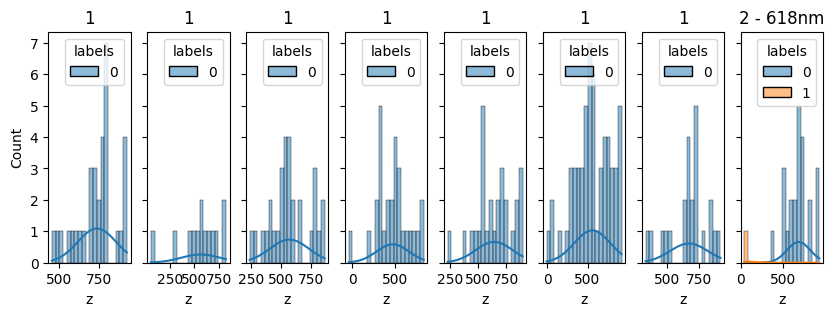

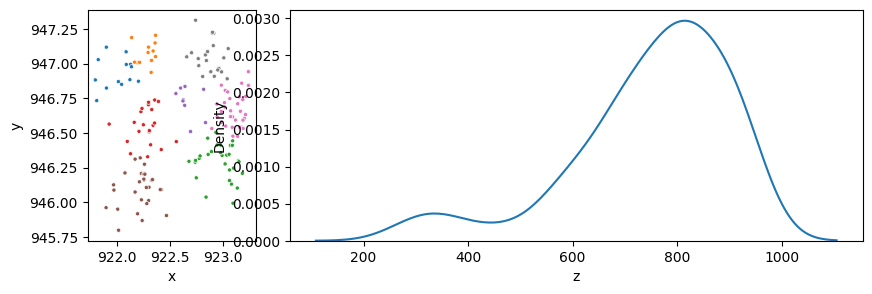

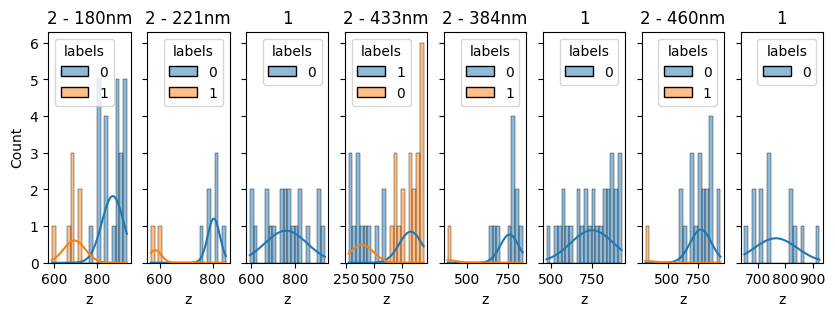

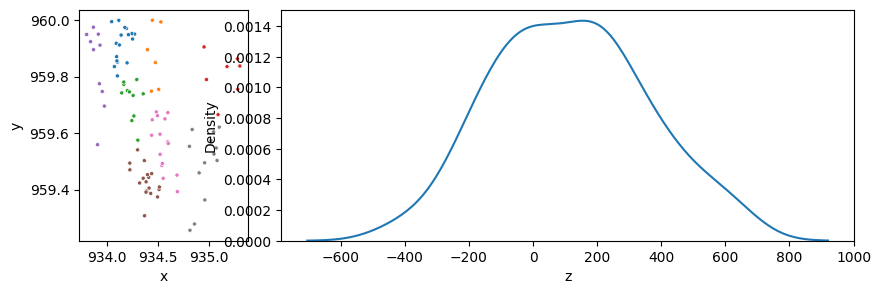

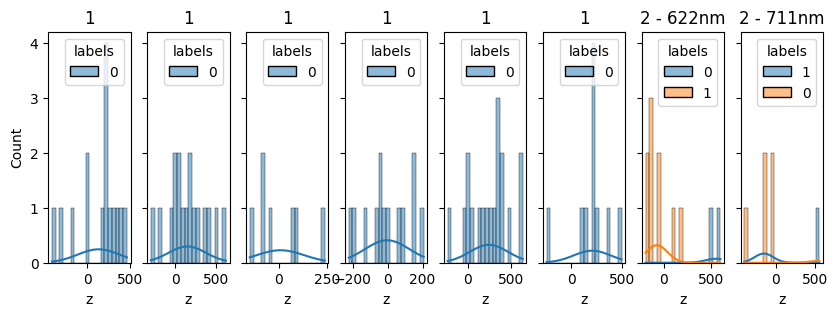

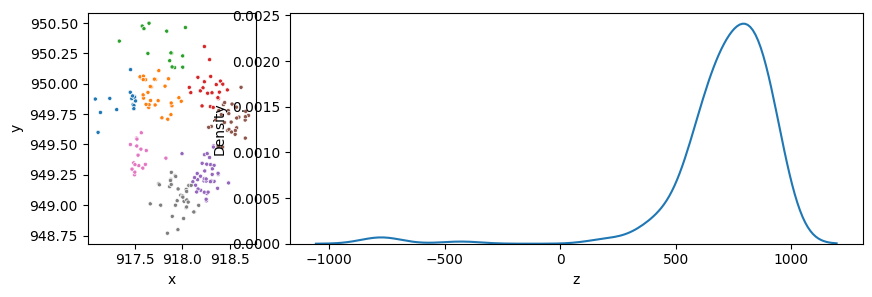

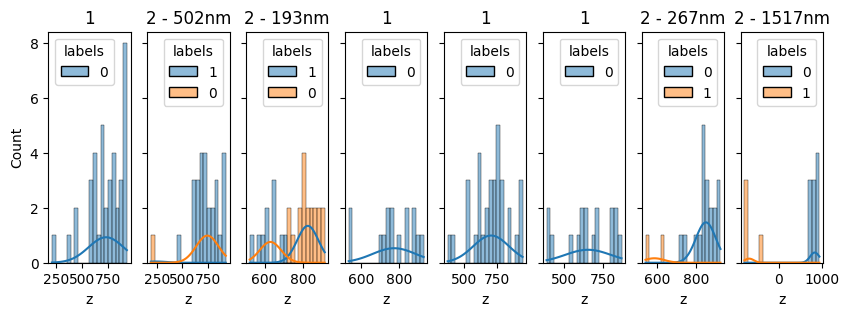

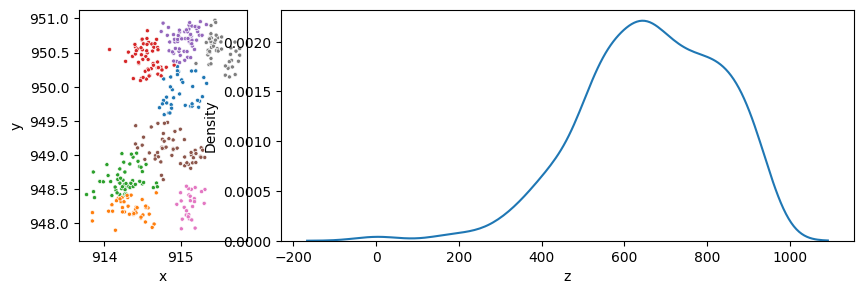

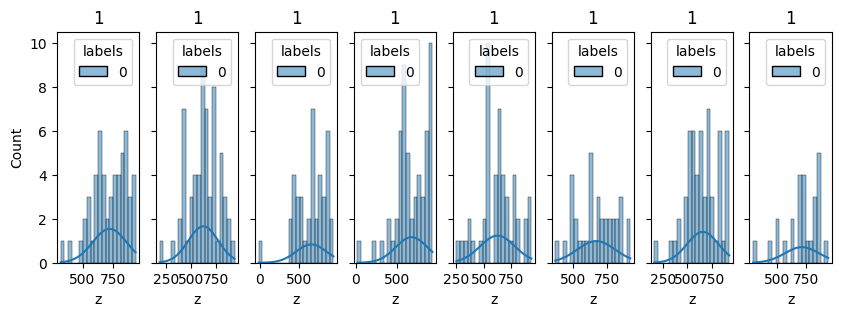

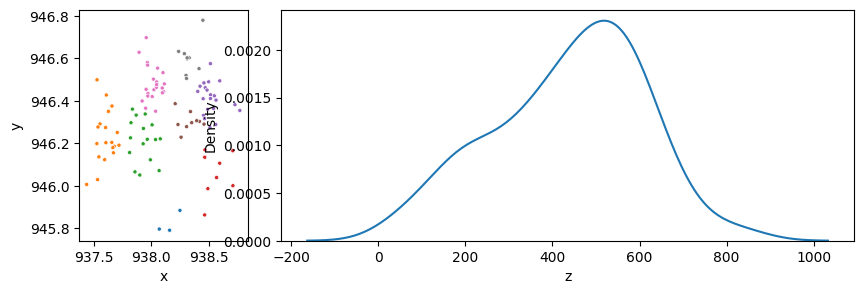

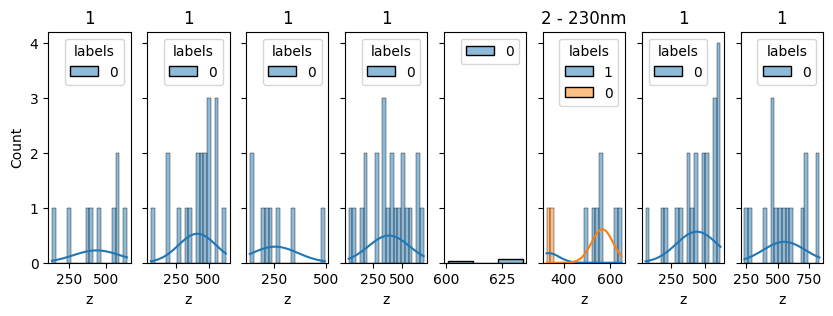

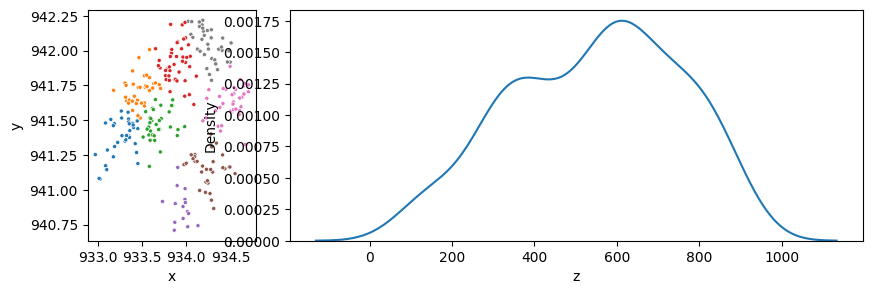

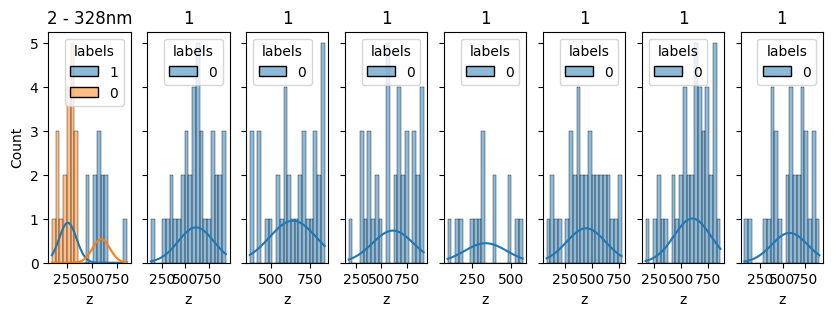

Exception ignored in: <function _xla_gc_callback at 0x7f1c1cd1b160>
Traceback (most recent call last):
  File "/home/miguel/Projects/uni/venv/lib/python3.8/site-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


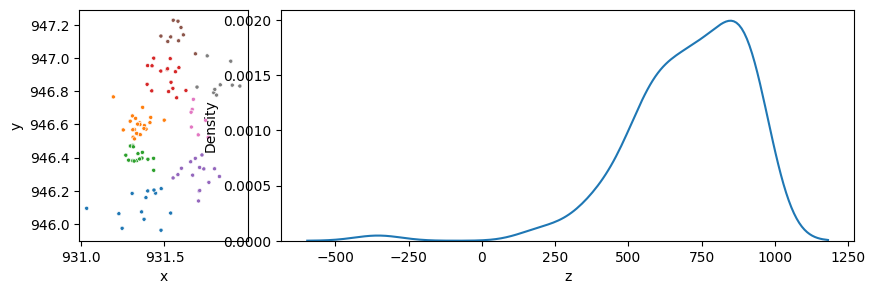

KeyboardInterrupt: 

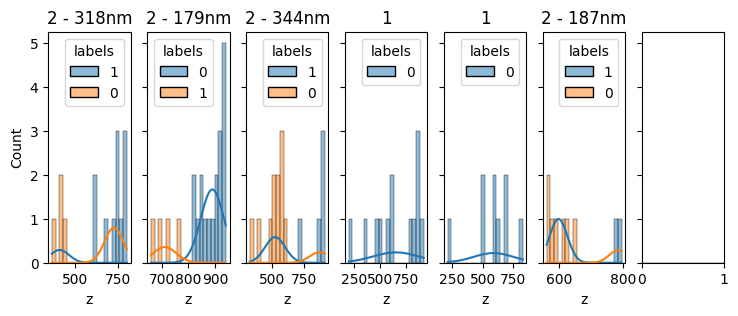

In [61]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import ParameterGrid
from scipy.stats import norm


def gmm_bic_score(estimator, X):
    return estimator.bic(X)

param_grid = {
    "n_components": range(1, 3),
    "covariance_type": ["tied"],
}


def get_n_components(data):
    
    res = []
    estimators = []
    for param in ParameterGrid(param_grid):
        gm = GaussianMixture(**param).fit(data)
        param['score'] = gm.bic(data)
        res.append(param)
        estimators.append(gm)
    
    df = pd.DataFrame.from_records(res)
    best_params = np.argmin(df['score'].to_numpy())
    return estimators[best_params]



def get_cov(gm, i):
    cov_type = gm.covariance_type
    if cov_type == 'tied':
        cov = gm.covariances_.squeeze()
    elif cov_type == 'full' or cov_type == None:
        cov = gm.covariances_[i][0][0]
    elif cov_type == 'spherical':
        cov = gm.covariances_[i]
    elif cov_type == 'diag':
        cov = gm.covariances_[i]
    
    return cov

def fit_gmm(ax, data):

    if len(data) < 5:
        sns.histplot(data, stat='density', ax=ax)
        return


    gm = get_n_components(data)
    df = pd.DataFrame.from_dict({
        'z': data.squeeze(),
        'labels': gm.predict(data).squeeze().astype(str)
    })
    
    sns.histplot(data=df, x='z', hue='labels', stat='count', bins=20, ax=ax)
    
    x = np.linspace(data.min(), data.max(), 100)
    
    point_count = len(data)

    for i in range(gm.n_components):
        cov = get_cov(gm, i)
        mean = float(gm.means_[i][0])
        weight = gm.weights_[i]
        ax.plot(x, norm.pdf(x, mean, np.sqrt(cov))*weight * point_count * 10, label=str(i))
    
    title = str(gm.n_components)   
    if gm.n_components == 2:
        diff_dist = round(abs(gm.means_[0][0]-gm.means_[1][0]))
        title += f' - {diff_dist}nm'
    ax.set_title(title)
    
picked_locs['z'] = pred_z
xyz = picked_locs[['x', 'y', 'z']].to_numpy()
xy = xyz[:, [0, 1]]

cls = DBSCAN(eps=0.3, min_samples=15).fit_predict(xy).astype(str)

picked_locs['clusterID'] = cls

plt.rcParams['figure.figsize'] = [5, 5]
sns.scatterplot(data=picked_locs, x='x', y='y', hue='clusterID', legend=False)
plt.show()


plt.rcParams['figure.figsize'] = [10, 3]
for cluster_id in sorted(set(cls)):
    if cluster_id == '-1':
        print('Ignoring cluster -1')
        continue
    cluster_locs = picked_locs[picked_locs['clusterID'] == cluster_id].copy()
    cluster_coords = cluster_locs[['x', 'y']].to_numpy()
    
    cluster_locs['sub_clusterID'] = KMeans(n_init=8, n_clusters=8).fit_predict(cluster_coords).astype(str)
    
    if cluster_locs.shape[0] < 50:
        continue
    
    fig = plt.figure()
    gs = fig.add_gridspec(1, 4)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1:4])

    sns.scatterplot(data=cluster_locs, x='x', y='y', marker='.', hue='sub_clusterID', ax=ax1, legend=False)
    sns.kdeplot(data=cluster_locs, x='z', ax=ax2)
    plt.show()

    fig2 = plt.figure()
    gs2 = fig2.add_gridspec(1, 8)
    axes = []
    for i in sorted(set(cluster_locs['sub_clusterID'])):
        if int(i) > 0:
            ax = fig2.add_subplot(gs2[0, int(i)], sharey=axes[0])
            plt.setp(ax.get_yticklabels(), visible=False)
        else:
            ax = fig2.add_subplot(gs2[0, int(i)])
        axes.append(ax)
        
        z_data = cluster_locs[cluster_locs['sub_clusterID']==i]['z'].to_numpy()[:, np.newaxis]
        fit_gmm(ax, z_data)
        
        
    plt.show()
    



[[609.87880049]
 [-81.01163557]]
{'n_components': 2, 'tol': 0.001, 'reg_covar': 1e-06, 'max_iter': 100, 'n_init': 1, 'init_params': 'kmeans', 'random_state': None, 'warm_start': False, 'verbose': 0, 'verbose_interval': 10, 'covariance_type': 'tied', 'weights_init': None, 'means_init': None, 'precisions_init': None, 'n_features_in_': 1, 'converged_': True, 'weights_': array([0.82383559, 0.17616441]), 'means_': array([[609.87880049],
       [-81.01163557]]), 'covariances_': array([[45245.73696865]]), 'precisions_cholesky_': array([[0.00470123]]), 'precisions_': array([[2.21015297e-05]]), 'n_iter_': 7, 'lower_bound_': -7.136615607627424}


NameError: name 'm' is not defined

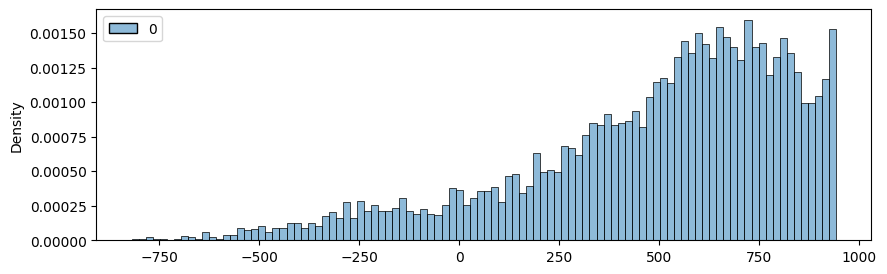

In [49]:
data = picked_locs['z'].to_numpy()[:, np.newaxis]
sns.histplot(data, stat='density', bins=100)


fit = get_n_components(data)
means = fit.means_
print(means)
print(fit.__dict__)
x = np.linspace(data.min(), data.max(), 100)

cov = fit.covariances_.squeeze()
for i in range(fit.n_components):
    mean = float(fit.means_[i][0])
    weight = fit.weights_[i]
    plt.plot(x, norm.pdf(x, m, np.sqrt(cov))*weight)
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [20, 20]

idx = np.argsort(pred_z.squeeze())
sorted_psfs = exp_psfs[idx]
plt.imshow(grid_psfs(sorted_psfs[::10]))


In [ ]:
plt.rcParams['figure.figsize'] = [5, 3]
for sd in [40]:
    p1 = np.random.normal(0, sd, size=10000)
    p2 = np.random.normal(50, sd, size=10000)
    data = np.concatenate((p1, p2))
    plt.title(f'Stdev: {sd}')
    sns.histplot(data)
    plt.xlabel('Z (nm)')
    plt.show()